In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import pymorphy2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.datasets import fetch_20newsgroups
import stop_words
import gensim
import nltk
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline

In [4]:
N_TOPICS = 4

In [5]:
data =  pd.read_csv('texts.csv')
data.head()

,politics,science,culture,economy
0,"('Встреча Лаврова и Зарифа прорабатывается, за...",('SpaceX: при запуске спутника Zuma ракета Fal...,('Партнерша Ведерникова по ГАБТ назвала его че...,('Цена на нефть марки Brent впервые с мая 2015...
1,('Путин обсудил с Силуановым и Пучковым госпро...,('Генетики раскрыли родословную первых викинго...,('Солистка Большого театра Татьяна Ерастова на...,('Цена на нефть марки WTI впервые с 2014 года ...
2,('Медведев назначил Шпади замглавы Росжелдора'...,('Ученые нашли в Австралии птиц с крыльями тем...,('Солист Большого театра Владимир Маторин отме...,('Натуральное свинство: чем грозит России иск ...
3,('Медведев освободил Луковникова от должности ...,('В Финляндии разработают спрей для лечения иг...,('Франшизы и супергерои: самые ожидаемые фильм...,('Россия попросит ВТО созвать панель арбитров ...
4,('ЦИК получил документы для регистрации Грудин...,"('РКК ""Энергия"" предложила заряжать лунные ста...","('Умер оперный певец Александр Ведерников', ' ...",('Тень независимости: почему Украина не соскоч...


In [6]:
import numpy as np
from pymystem3 import Mystem
m = Mystem()

def clean(x):
    res = []
    for word in x:
        if (' ' not in word) and ('\n' not in word):
            res.append(word)
    return np.array(res)
        

def preprocess(x): 
    x = x.replace('?', '.').replace('!', '.')
    x = re.sub(r'[^\w\s]', ' ', x.lower())
    x = re.sub('\d', ' ', x)
    x = re.sub(r'[\n\r\t]', ' ', x)
    x = ' '.join(re.split("[^а-я]*", x.lower()))
    x = m.lemmatize(x)
    x = clean(x)
    return ' '.join(x)

In [7]:
for col in data.columns:
    data[col] = data[col].apply(lambda x: preprocess(x))
data.head()

/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


,politics,science,culture,economy
0,встреча лавров и зарифа прорабатываться заявля...,при запуск спутник ракета работать штатный ком...,партнерша ведерникова по габт называть он чело...,цена на нефть марка впервые с май год превышат...
1,путин обсуждать с силуанов и пучков госпрограм...,генетик раскрывать родословная первый викинг с...,солистка большой театр татьяна ерастова называ...,цена на нефть марка впервые с год превышать за...
2,медведев назначать шпадь замглавы росжелдор пр...,ученый находить в австралия птица с крыло темн...,солист большой театр владимир маторина отмечат...,натуральный свинство что грозить россия иск ев...
3,медведев освобождать луковников от должность з...,в финляндия разрабатывать спрей для лечение иг...,франшиза и супергерой самый ожидать фильм год ...,россия попросить вто созывать панель арбитр по...
4,цик получать документ для регистрация грудинин...,ркк энергия предлагать заряжать лунный станция...,умирать оперный певец александр ведерников сов...,тень независимость почему украина не соскакива...


In [8]:
dz2 = []
for col in data.columns:
    for line in data[col]:
        dz2.append([col, line])
dz2 = pd.DataFrame(dz2)
dz2.columns = ['label', 'text']
dz2.head()

,label,text
0,politics,встреча лавров и зарифа прорабатываться заявля...
1,politics,путин обсуждать с силуанов и пучков госпрограм...
2,politics,медведев назначать шпадь замглавы росжелдор пр...
3,politics,медведев освобождать луковников от должность з...
4,politics,цик получать документ для регистрация грудинин...


***LSA***

LSA = TFIDF + SVD

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(dz2.text)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(800, 14174)

In [10]:
keys = list(count_vect.vocabulary_.keys())
values = list(count_vect.vocabulary_.values())

_ind = np.argsort(values)
words_sorted = np.asarray(keys)[_ind]

print(len(keys), len(values), len(words_sorted))

14174 14174 14174


In [11]:
N_TOPICS = 4
svd = TruncatedSVD(n_components=N_TOPICS, n_iter=10).fit(X_train_counts)

['этот' 'он' 'который' 'это' 'по' 'год' 'не' 'быть' 'что' 'на']
[0.14582898 0.14992837 0.15668938 0.16016262 0.20561814 0.21030667
 0.24793947 0.25302075 0.30994471 0.47189822]

['путин' 'на' 'подпись' 'выборы' 'цик' 'избирательный' 'россия' 'партия'
 'президент' 'кандидат']
[0.13579026 0.13951727 0.15276133 0.1625743  0.19957096 0.21107689
 0.21341478 0.22701195 0.2280147  0.35098059]

['рынок' 'миллиард' 'до' 'ставка' 'доллар' 'процент' 'за' 'по' 'год' 'на']
[0.05639443 0.06189236 0.06873756 0.07208325 0.07613211 0.07752128
 0.09502415 0.14502373 0.41631148 0.45245627]

['цик' 'этот' 'на' 'из' 'партия' 'как' 'кандидат' 'от' 'они' 'ученый']
[0.11140189 0.11223313 0.1156421  0.13662421 0.14190919 0.16521465
 0.18241829 0.18748953 0.20110572 0.24826585]



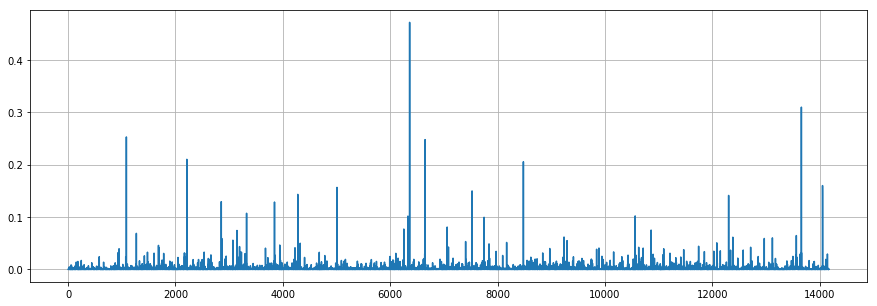

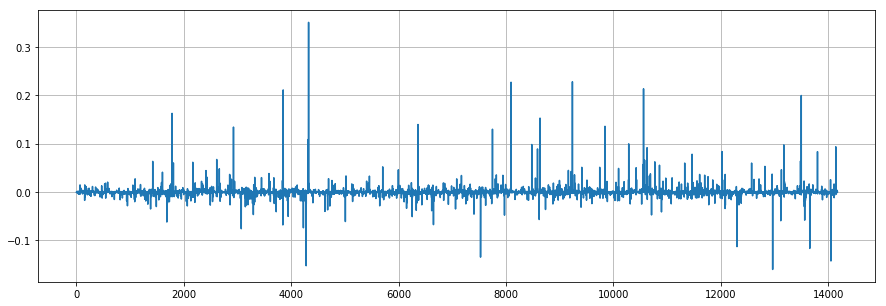

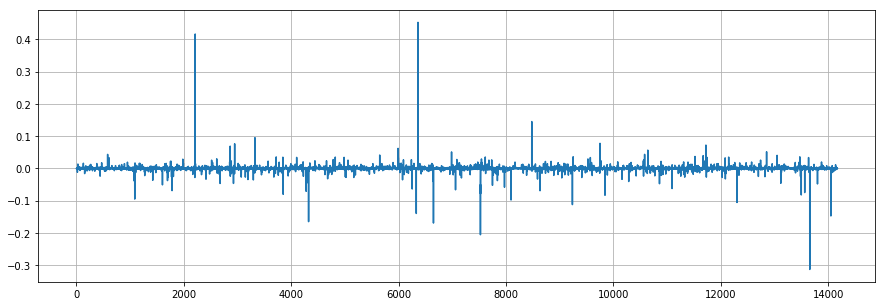

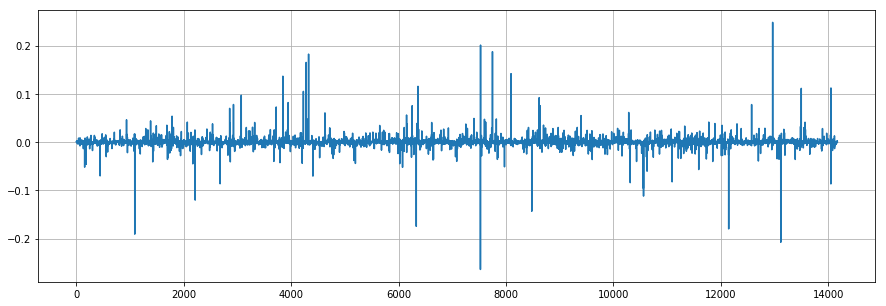

In [12]:
stub = [0] * N_TOPICS

for i in range(N_TOPICS):
    ind = np.argsort(svd.components_[i])[-10:]
    print(words_sorted[ind])
    print(np.sort(svd.components_[i])[-10:])
    print()
    
    tmp = stub.copy()
    tmp[i] = 1
    plt.figure(figsize=(15, 5))
    plt.plot(svd.components_[i])
    plt.grid(True)

***Темы*** 1) не очень ясна 2)выборы путина 3)экономика 4)выборы

***LDA ***

LDA = LSA + Dirichlet

gensim

In [13]:
N_TOPICS = 10

In [14]:
corpus = []

for i in dz2.text:
    tokens = i.split(' ')
    tokens = [t for t in tokens if len(t) >= 4]
    corpus.append(tokens)

In [15]:
dictionary = corpora.Dictionary(corpus)

In [16]:
X_bow = [dictionary.doc2bow(text) for text in corpus]


In [17]:
lda_gensim = gensim.models.ldamodel.LdaModel(X_bow, num_topics=N_TOPICS, id2word=dictionary, iterations=10)

In [18]:
lda_gensim.print_topics()

[(0,
  '0.010*"быть" + 0.009*"этот" + 0.006*"который" + 0.004*"весь" + 0.004*"россия" + 0.004*"ученый" + 0.003*"свой" + 0.003*"сообщать" + 0.003*"российский" + 0.003*"другой"'),
 (1,
  '0.009*"который" + 0.008*"быть" + 0.008*"этот" + 0.006*"россия" + 0.006*"президент" + 0.005*"российский" + 0.004*"весь" + 0.004*"сообщать" + 0.004*"ученый" + 0.003*"мочь"'),
 (2,
  '0.013*"быть" + 0.007*"который" + 0.006*"этот" + 0.005*"мочь" + 0.005*"россия" + 0.004*"российский" + 0.004*"первый" + 0.004*"другой" + 0.003*"также" + 0.003*"президент"'),
 (3,
  '0.010*"быть" + 0.009*"который" + 0.008*"этот" + 0.006*"россия" + 0.004*"президент" + 0.004*"мочь" + 0.004*"также" + 0.004*"свой" + 0.003*"российский" + 0.003*"один"'),
 (4,
  '0.013*"быть" + 0.007*"этот" + 0.007*"россия" + 0.006*"который" + 0.006*"российский" + 0.004*"ученый" + 0.004*"свой" + 0.003*"другой" + 0.003*"мочь" + 0.003*"человек"'),
 (5,
  '0.015*"быть" + 0.008*"который" + 0.007*"россия" + 0.006*"этот" + 0.004*"мочь" + 0.004*"сообщать" + 0

***ТЕмы*** 1)наука 2)президент 3)президент 4)президент 5)наука 6)выборы 7)президент 8)выборы 9)выборы 10)выборы

***sklearn***

In [19]:
N_TOPICS = 3

In [20]:
lda_sklearn = LatentDirichletAllocation(n_components=N_TOPICS, max_iter=10, batch_size=10, evaluate_every=1, verbose=1, 
                                        n_jobs=4, learning_method='batch').fit(X_train_tfidf)

iteration: 1 of max_iter: 10, perplexity: 29470.7792
iteration: 2 of max_iter: 10, perplexity: 26728.8138
iteration: 3 of max_iter: 10, perplexity: 23284.0667
iteration: 4 of max_iter: 10, perplexity: 21419.9620
iteration: 5 of max_iter: 10, perplexity: 20471.3992
iteration: 6 of max_iter: 10, perplexity: 20007.9915
iteration: 7 of max_iter: 10, perplexity: 19755.6878
iteration: 8 of max_iter: 10, perplexity: 19562.4028
iteration: 9 of max_iter: 10, perplexity: 19428.3005
iteration: 10 of max_iter: 10, perplexity: 19362.2347


In [21]:
lda_sklearn.components_.shape

(3, 14174)

In [22]:
stub = [0] * N_TOPICS

for i in range(N_TOPICS):
    ind = np.argsort(lda_sklearn.components_[i])[-10:]
    print(words_sorted[ind])
    print(np.sort(svd.components_[i])[-10:])
    print()
#     break

['винсент' 'сингер' 'ларен' 'голландский' 'выставляться' 'атрибутировать'
 'амстердамский' 'ван' 'рисунок' 'гог']
[0.14582898 0.14992837 0.15668938 0.16016262 0.20561814 0.21030667
 0.24793947 0.25302075 0.30994471 0.47189822]

['президент' 'он' 'который' 'россия' 'по' 'не' 'быть' 'год' 'что' 'на']
[0.13579026 0.13951727 0.15276133 0.1625743  0.19957096 0.21107689
 0.21341478 0.22701195 0.2280147  0.35098059]

['аллен' 'сольный' 'альбом' 'вокалистка' 'солистка' 'ирландский' 'долорес'
 'певица' 'ведерников' 'риордан']
[0.05639443 0.06189236 0.06873756 0.07208325 0.07613211 0.07752128
 0.09502415 0.14502373 0.41631148 0.45245627]



***Темы*** 1)живопись 2)политика 3)музыка